# ARPF

## Goal

* Why accuracy is not always the best measure of performance
* Other performance measures in ml
* The relationship between recall and sensitivity

$$ Accuracy = \frac{TP + TN}{\text{Total #}} $$

OVerall model performance, ignoring categories and sample sizes.

$$ Precission = \frac{TP}{\text{Total # of Positives}} $$

Includes a cost for 'yes' biases. Useful when false positives are bad, like cancer detection.

$$ Recall = \frac{TP}{\text{Total # Real Positives (TP + FN)}} $$

Includes a cost for "no" biases. Useful when false negatives are bad, like covid19.

$$ F1 = \frac{TP}{TP + \frac{FP+FN}{2}} $$

Balance between precision and recall. F1 score is high only with few mistakes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size':18})

## Experiment

In [ ]:
N = 50
num_exp = 10000

accuracy = np.zeros(num_exp)
precision = np.zeros(num_exp)
recall = np.zeros(num_exp)
F1score = np.zeros(num_exp)

for exp_i in range(num_exp):
  TP = np.random.randint(1, N)
  FP = N - TP
  TN = np.random.randint(1, N)
  FN = N - TN

  accuracy[exp_i] = (TP + TN) / (2*N)
  precision[exp_i] = TP / (TP + FP)
  recall[exp_i] = TP / (TP + FN)
  F1score[exp_i] = TP / (TP + (FN + FP) / 2)

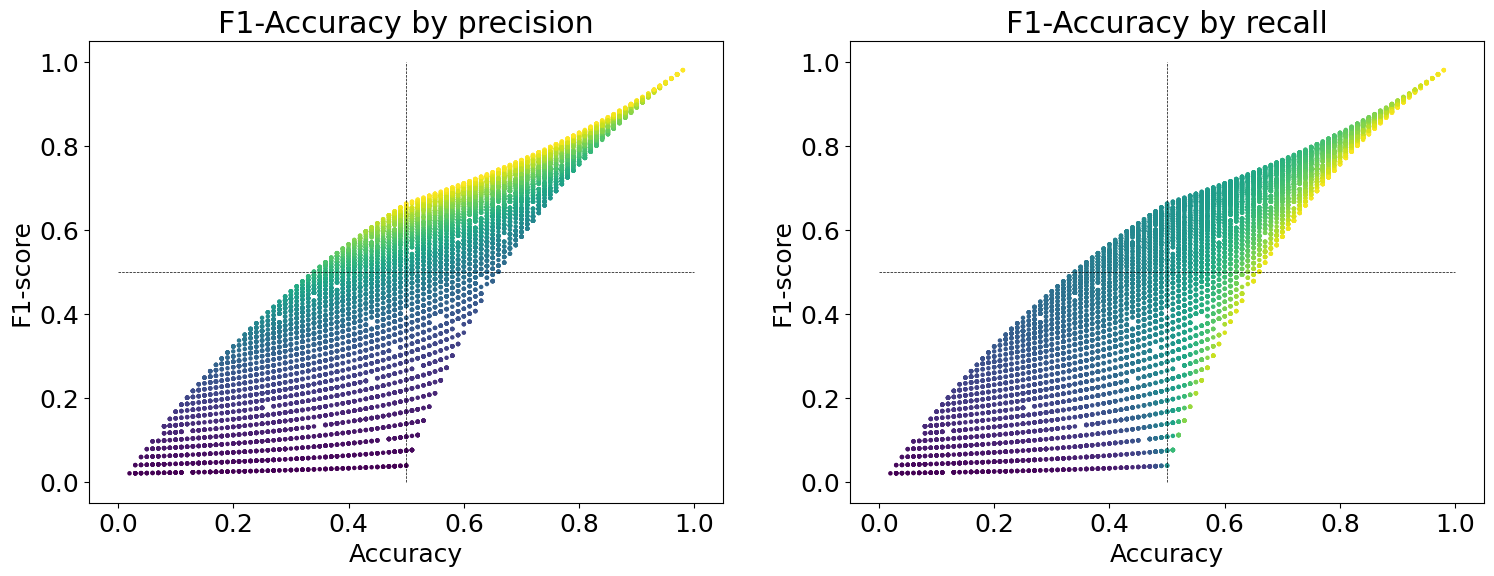

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

ax[0].scatter(accuracy, F1score, s = 5, c = precision)
ax[0].plot([0,1],[.5,.5], 'k--', linewidth = .5)
ax[0].plot([.5,.5],[0,1], 'k--', linewidth = .5)
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('F1-score')
ax[0].set_title('F1-Accuracy by precision')

ax[1].scatter(accuracy, F1score, s = 5, c = recall)
ax[1].plot([0,1],[.5,.5], 'k--', linewidth=.5)
ax[1].plot([.5,.5],[0,1],'k--',linewidth=.5)
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel('F1-score')
ax[1].set_title('F1-Accuracy by recall')
# cbar = fig.colorbar(sc, ax = ax[1])
# cbar.set_label('Precision')

plt.show()

# Wine Quality

## Data

In [ ]:
import pandas as pd

import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import time

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
                 sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


/tmp/ipython-input-1455282660.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


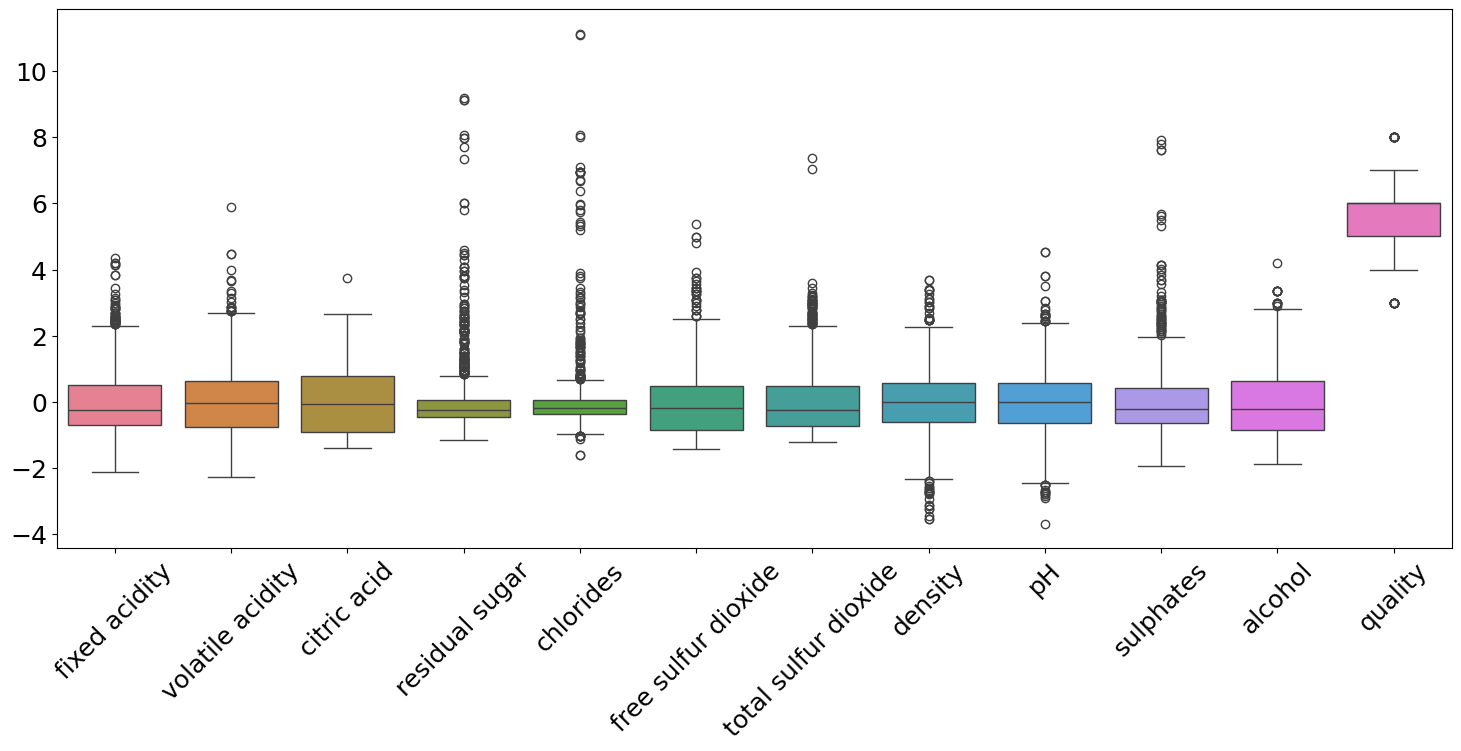

In [ ]:
cols_2_zscore = df.keys().drop('quality')
df[cols_2_zscore] = df[cols_2_zscore].apply(stats.zscore)

fig, ax = plt.subplots(1, figsize = (18, 7))

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

/tmp/ipython-input-4154025787.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['bool_quality'].loc[df['quality'] > 5] = 1
/tmp/ipython-input-4154025787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

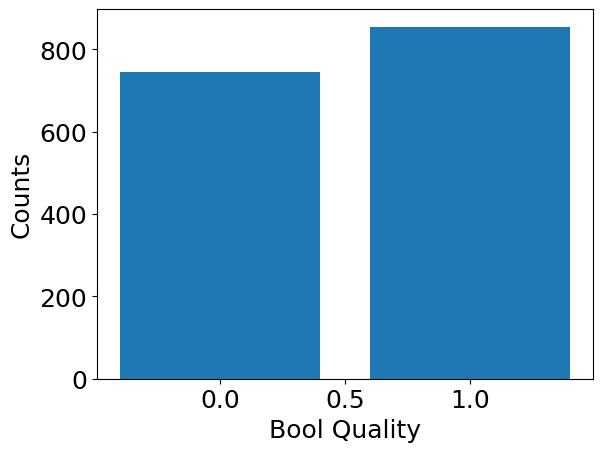

In [ ]:
df['bool_quality'] = 0
df['bool_quality'].loc[df['quality'] > 5] = 1
df['bool_quality'].value_counts()
plt.bar(df['bool_quality'].value_counts().keys(), list(df['bool_quality'].value_counts()))
plt.xlabel('Bool Quality')
plt.ylabel('Counts')
plt.show()

In [ ]:
data = torch.tensor(df[cols_2_zscore].values).float()
labels = torch.tensor(df['bool_quality'].values).float()

data.shape, labels.shape

(torch.Size([1599, 11]), torch.Size([1599]))

In [ ]:
labels = labels[:, None]
data.shape, labels.shape

(torch.Size([1599, 11]), torch.Size([1599, 1]))

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = .8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = X_train.shape[0])

## Model Arch

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(11, 32)
    self.bn1 = nn.BatchNorm1d(32)

    self.fc1 = nn.Linear(32, 64)
    self.bn2 = nn.BatchNorm1d(64)

    self.fc2 = nn.Linear(64, 32)
    self.bn3 = nn.BatchNorm1d(32)

    self.dropout = nn.Dropout(0.4)
    self.output = nn.Linear(32, 1)

  def forward(self, x):
    # warstwa 1
    x = self.input(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.dropout(x)

    # warstwa 2
    x = self.fc1(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.dropout(x)

    # warstwa 3
    x = self.fc2(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.dropout(x)

    # output
    x = self.output(x)

    return x

## Model Setup

In [ ]:
def ModelSetup():
  ann = Model()
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(ann.parameters(), lr = 1e-2)

  return ann, loss_fn, optimizer

## Model Train

In [ ]:
def ModelTrain(epochs):
  ann, loss_fn, optimizer = ModelSetup()

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):
      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      pred = (batch_y_hat.squeeze(1) >= 0).long()
      targ = y_train.squeeze(1).long()
      batch_acc = 100 * (pred == targ).float().mean()
      batch_accs[batch] = batch_acc

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()


    train_losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)

    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss

    pred = (test_y_hat.squeeze(1) >= 0).long()
    targ = y_test.squeeze(1).long()
    test_acc = 100 * (pred == targ).float().mean()
    test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Epoch: {epoch} | Train -> Acc: {train_accs[epoch]:2f} Loss: {train_losses[epoch]:2f} | Test -> Acc: {test_acc:2f} Loss: {test_loss:2f}')

  return train_losses, train_accs, test_losses, test_accs, ann

## Model Run

In [ ]:
train_losses, train_accs, test_losses, test_accs, ann = ModelTrain(epochs = 500)

Epoch: 0 | Train -> Acc: 67.516449 Loss: 0.602283 | Test -> Acc: 72.500000 Loss: 0.539733
Epoch: 10 | Train -> Acc: 75.904602 Loss: 0.511008 | Test -> Acc: 74.687500 Loss: 0.488428
Epoch: 20 | Train -> Acc: 77.467102 Loss: 0.499280 | Test -> Acc: 77.187500 Loss: 0.477158
Epoch: 30 | Train -> Acc: 77.796051 Loss: 0.485062 | Test -> Acc: 77.187500 Loss: 0.493320
Epoch: 40 | Train -> Acc: 76.069077 Loss: 0.504511 | Test -> Acc: 75.937500 Loss: 0.486679
Epoch: 50 | Train -> Acc: 77.220398 Loss: 0.500295 | Test -> Acc: 75.937500 Loss: 0.489989
Epoch: 60 | Train -> Acc: 78.125000 Loss: 0.489503 | Test -> Acc: 75.625000 Loss: 0.487056
Epoch: 70 | Train -> Acc: 77.384865 Loss: 0.483583 | Test -> Acc: 75.000000 Loss: 0.491133
Epoch: 80 | Train -> Acc: 77.631577 Loss: 0.501850 | Test -> Acc: 75.312500 Loss: 0.493986
Epoch: 90 | Train -> Acc: 77.960526 Loss: 0.475553 | Test -> Acc: 76.562500 Loss: 0.483832
Epoch: 100 | Train -> Acc: 75.328949 Loss: 0.483065 | Test -> Acc: 75.312500 Loss: 0.494210

## Performance Measures

In [ ]:
train_preds = ann(train_dataloader.dataset.tensors[0])
test_preds = ann(test_dataloader.dataset.tensors[0])

In [ ]:
import sklearn.metrics as skm

train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

train_metrics[0] = skm.accuracy_score(train_dataloader.dataset.tensors[1],train_preds>0)
train_metrics[1] = skm.precision_score(train_dataloader.dataset.tensors[1],train_preds>0)
train_metrics[2] = skm.recall_score(train_dataloader.dataset.tensors[1],train_preds>0)
train_metrics[3] = skm.f1_score(train_dataloader.dataset.tensors[1],train_preds>0)

test_metrics[0] = skm.accuracy_score(test_dataloader.dataset.tensors[1], test_preds>1)
test_metrics[1] = skm.precision_score(test_dataloader.dataset.tensors[1], test_preds>1)
test_metrics[2] = skm.recall_score(test_dataloader.dataset.tensors[1], test_preds>1)
test_metrics[3] = skm.f1_score(test_dataloader.dataset.tensors[1], test_preds>1)

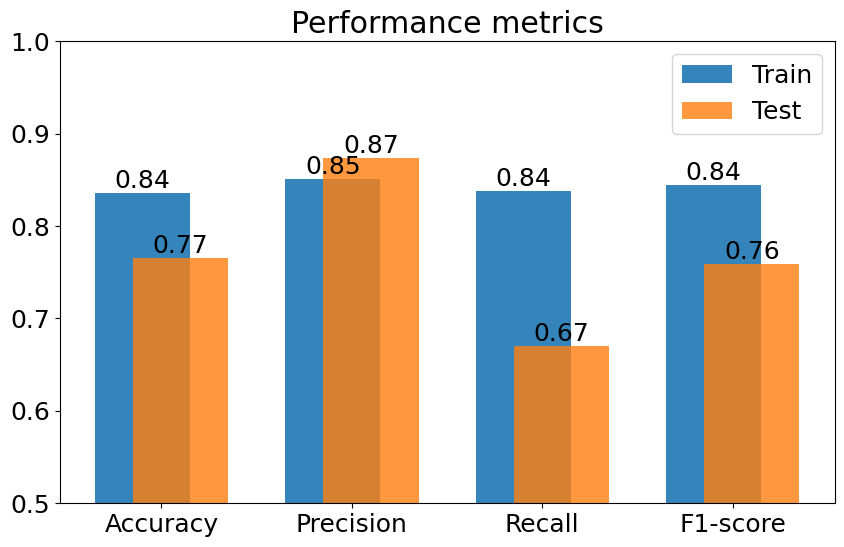

In [ ]:
fig = plt.figure(figsize = (10,6))

plt.bar(np.arange(4) - .1, train_metrics, .5, alpha=.9)
plt.bar(np.arange(4) + .1, test_metrics, .5, alpha=.8)
plt.xticks([0,1,2,3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.5,1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')

for i, tr, te in zip(range(4), train_metrics, test_metrics):
  plt.text(i - .1, tr, f'{tr:.2f}', ha = 'center', va = 'bottom')
  plt.text(i + .1, te, f'{te:.2f}', ha = 'center', va = 'bottom')

plt.show()

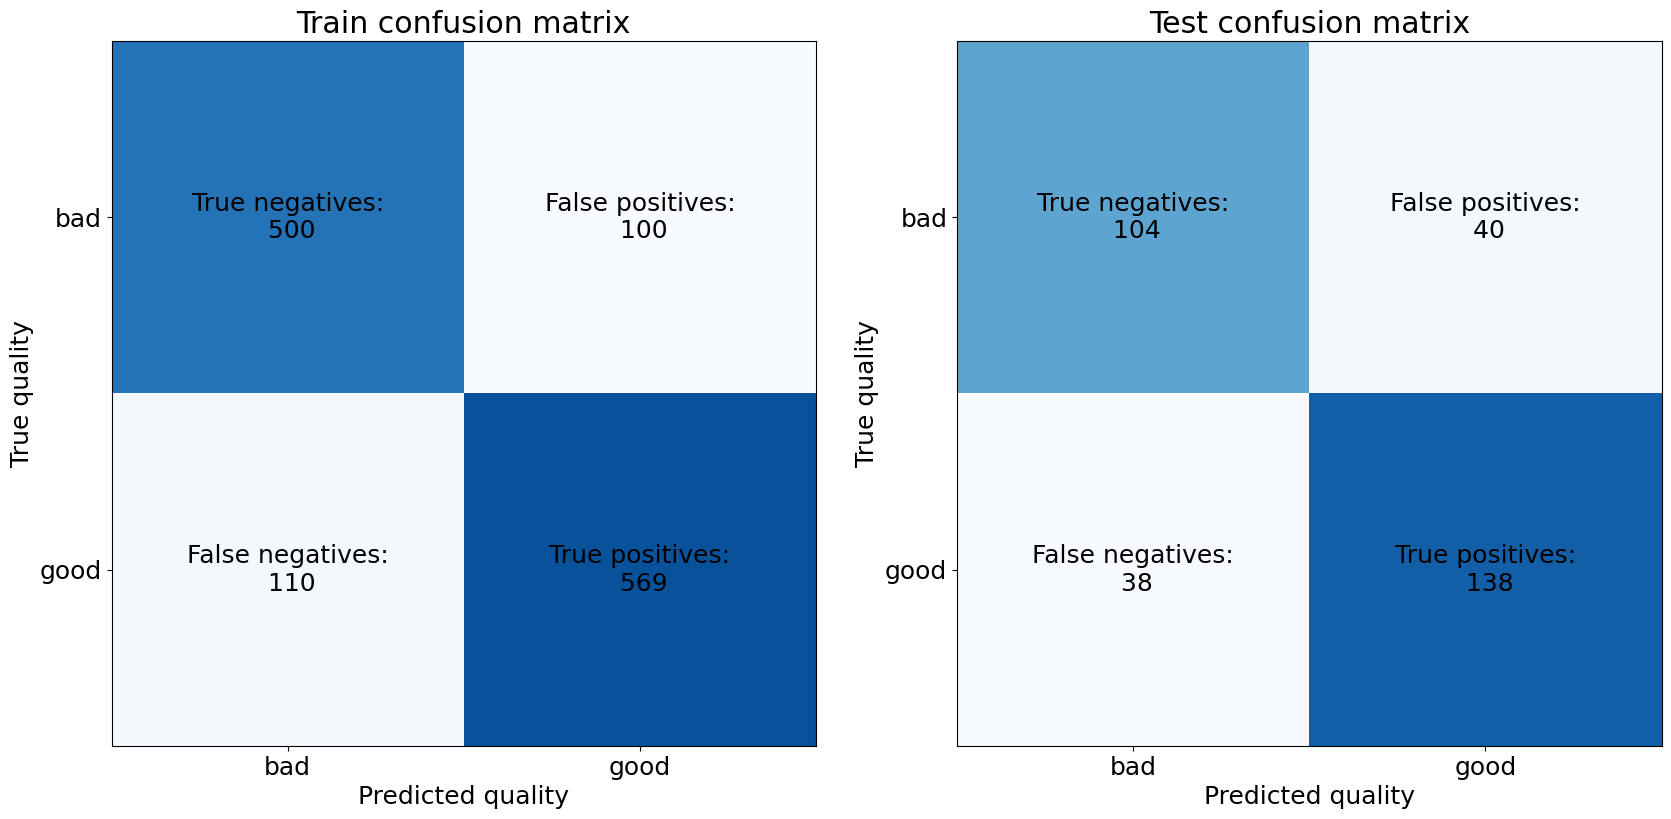

In [ ]:
train_conf = skm.confusion_matrix(train_dataloader.dataset.tensors[1], train_preds>0)
test_conf = skm.confusion_matrix(test_dataloader.dataset.tensors[1], test_preds>0)

fig, ax = plt.subplots(1,2,figsize = (20,10))

ax[0].imshow(train_conf, 'Blues', vmax = len(train_preds)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad', 'good'])
ax[0].set_yticklabels(['bad', 'good'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('Train confusion matrix')

ax[0].text(0,0,f'True negatives:\n {train_conf[0,0]}', ha = 'center', va = 'center')
ax[0].text(0,1,f'False negatives:\n {train_conf[1,0]}', ha = 'center', va = 'center')
ax[0].text(1,1,f'True positives:\n {train_conf[1,1]}', ha = 'center', va = 'center')
ax[0].text(1,0,f'False positives:\n {train_conf[0,1]}', ha = 'center', va = 'center')

ax[1].imshow(test_conf, 'Blues', vmax = len(test_preds)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad', 'good'])
ax[1].set_yticklabels(['bad', 'good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('Test confusion matrix')

ax[1].text(0,0,f'True negatives:\n {test_conf[0,0]}', ha = 'center', va = 'center')
ax[1].text(0,1,f'False negatives:\n {test_conf[1,0]}', ha = 'center', va = 'center')
ax[1].text(1,1,f'True positives:\n {test_conf[1,1]}', ha = 'center', va = 'center')
ax[1].text(1,0,f'False positives:\n {test_conf[0,1]}', ha = 'center', va = 'center')

plt.show()

# MNIST

## Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-1998786568.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')
data

array([[6., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [ ]:
labels = data[:,0]
data = data[:,1:]
data_norm = data / np.max(data)
labels.shape, data_norm.shape

((20000,), (20000, 784))

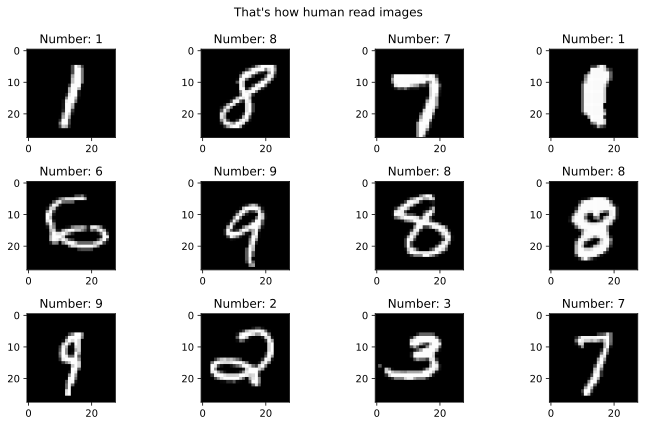

In [ ]:
fig, axs = plt.subplots(3,4,figsize = (10, 6))

for ax in axs.flatten():
  random_row = np.random.randint(0, data.shape[0])
  img = np.reshape(data[random_row], (28,28))

  ax.imshow(img, cmap = 'grey')
  ax.set_title(f'Number: %i' %labels[random_row])

plt.suptitle('That\'s how human read images')
plt.tight_layout()
plt.show()

## Split

In [ ]:
data = torch.tensor(data_norm).float()
labels = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

## Model

In [ ]:
def CreateNet():

  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 64)

      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      self.output = nn.Linear(32,10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return x

  net = Net()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
  return net, loss_fn, optimizer

CreateNet()

(Net(
   (input): Linear(in_features=784, out_features=64, bias=True)
   (fc1): Linear(in_features=64, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=32, bias=True)
   (output): Linear(in_features=32, out_features=10, bias=True)
 ),
 CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [ ]:
net, loss_fn, optimizer = CreateNet()
X, y = next(iter(train_dataloader))
y_hat = net(X)
loss = loss_fn(y_hat, y)
acc = 100 * torch.mean(
    (torch.argmax(y_hat, axis = 1) == y). float()
)
print(f'First spin Accuracy: {acc:.5f}% ')

First spin Accuracy: 6.25000% 


## Train

In [ ]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            y_hat = net(X)
            preds = torch.argmax(y_hat, axis=1)
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_acc = 100 * test_correct / test_total

    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses, net

In [ ]:
train_acc, test_acc, losses, net = ModelTrain(100, verbose = True)

Epoch: 0 | Train Acc: 20.73 | Test Acc: 30.18 | Loss: 2.29
Epoch: 10 | Train Acc: 91.32 | Test Acc: 91.45 | Loss: 0.30
Epoch: 20 | Train Acc: 95.27 | Test Acc: 94.22 | Loss: 0.17
Epoch: 30 | Train Acc: 97.04 | Test Acc: 95.05 | Loss: 0.11
Epoch: 40 | Train Acc: 98.34 | Test Acc: 95.38 | Loss: 0.07
Epoch: 50 | Train Acc: 98.99 | Test Acc: 95.78 | Loss: 0.04
Epoch: 60 | Train Acc: 99.53 | Test Acc: 95.90 | Loss: 0.02
Epoch: 70 | Train Acc: 99.79 | Test Acc: 95.92 | Loss: 0.02
Epoch: 80 | Train Acc: 99.92 | Test Acc: 95.95 | Loss: 0.01
Epoch: 90 | Train Acc: 99.97 | Test Acc: 95.78 | Loss: 0.01


## ARPF

In [ ]:
y_hat = net(train_dataloader.dataset.tensors[0])
train_preds = torch.argmax(y_hat, axis = 1)

y_hat = net(test_dataloader.dataset.tensors[0])
test_preds = torch.argmax(y_hat, axis = 1)

In [ ]:
import sklearn.metrics as skm

# we have 10 classes, so we have 10 precision values

## option 1: compute average precision, weighted by N
skm.precision_score(train_dataloader.dataset.tensors[1], train_preds, average = None)

## option 2: compute average precision, weighted by N
skm.precision_score(train_dataloader.dataset.tensors[1], train_preds, average = 'weighted')

## option 3: compute average precision, unweighted
skm.precision_score(train_dataloader.dataset.tensors[1], train_preds, average = 'macro')

0.9998724282246044

In [ ]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# train
train_metrics[0] = skm.accuracy_score(train_dataloader.dataset.tensors[1], train_preds) # accuracy is overall
train_metrics[1] = skm.precision_score(train_dataloader.dataset.tensors[1], train_preds, average = 'weighted')
train_metrics[2] = skm.recall_score(train_dataloader.dataset.tensors[1], train_preds, average = 'weighted')
train_metrics[3] = skm.f1_score(train_dataloader.dataset.tensors[1], train_preds, average = 'weighted')

# test
test_metrics[0] = skm.accuracy_score(test_dataloader.dataset.tensors[1], test_preds) # accuracy is overall
test_metrics[1] = skm.precision_score(test_dataloader.dataset.tensors[1], test_preds, average = 'weighted')
test_metrics[2] = skm.recall_score(test_dataloader.dataset.tensors[1], test_preds, average = 'weighted')
test_metrics[3] = skm.f1_score(test_dataloader.dataset.tensors[1], test_preds, average = 'weighted')

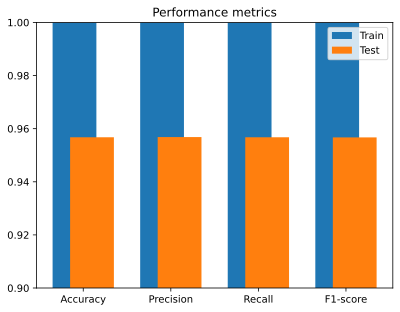

In [ ]:
plt.bar(np.arange(4) - .1, train_metrics, .5)
plt.bar(np.arange(4) + .1, test_metrics, .5)
plt.xticks([0,1,2,3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.9, 1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

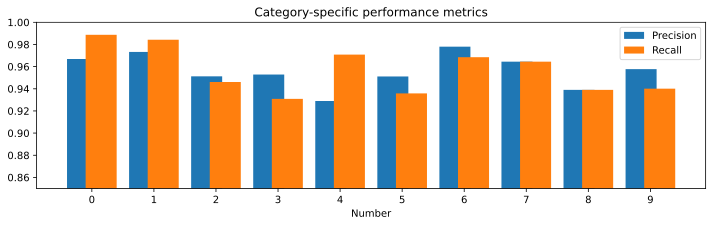

In [ ]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_dataloader.dataset.tensors[1], test_preds, average = None)
recall = skm.recall_score(test_dataloader.dataset.tensors[1], test_preds, average = None)

fig = plt.figure(figsize = (12,3))
plt.bar(np.arange(10) - .15, precision, .5)
plt.bar(np.arange(10) + .15, recall, .5)
plt.xticks(range(10), range(10))
plt.ylim([.85, 1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Category-specific performance metrics')
plt.show()

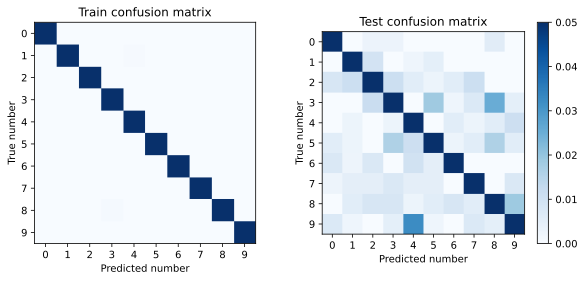

In [ ]:
train_conf = skm.confusion_matrix(train_dataloader.dataset.tensors[1], train_preds, normalize = 'true')
test_conf = skm.confusion_matrix(test_dataloader.dataset.tensors[1], test_preds, normalize = 'true')

fig, ax = plt.subplots(1,2,figsize=(10,4))

# confmat during train
ax[0].imshow(train_conf, 'Blues', vmax = .05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('Train confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

a = ax[1].imshow(test_conf, 'Blues', vmax = .05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('Test confusion matrix')
ax[1].set_xlabel('True number')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

# MNIST with unequal groups

Goal:

* Reduce the number of 7's to 500 (randomly selected)
* Inspect the item-specific performance metrics

## Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-1998786568.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [124]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

# select labels and data
labels = data[:,0]
data = data[:,1:]

### Reduce 7's to 500

In [125]:
# split into data - without 7, and data7 with 7
data7 = data[labels == 7]
labels7 = labels[labels == 7]

data = data[labels != 7]
labels = labels[labels != 7]

Check

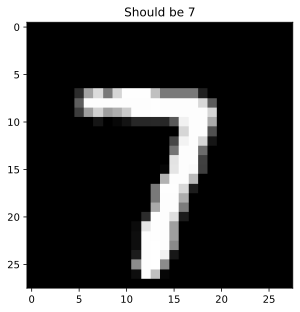

In [127]:
rand_row = np.random.randint(data7.shape[0])

plt.imshow(np.reshape(data7[rand_row], (28,28)), cmap = 'grey')
plt.title('Should be 7')
plt.show()

Pick 500 random 7's

In [128]:
# pick random 500 sample of 7's
random_500_7 = np.random.choice(data7.shape[0], 500)
data7 = data7[random_500_7]
labels7 = labels7[random_500_7]

# concat 7's sample to main data
data = np.vstack([data, data7])
labels = np.hstack([labels, labels7])

# shuffle all rows
shuffled_rows = np.random.choice(data.shape[0], data.shape[0], replace=False)
data = data[shuffled_rows]
labels = labels[shuffled_rows]

# to torch
data = torch.tensor(data).float()
labels = torch.tensor(labels).long()

# norm
data = data / torch.max(data)

Check again

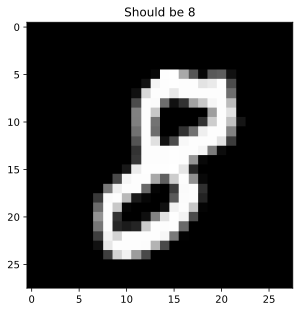

In [130]:
# check again
rand_row = np.random.randint(data.shape[0])

plt.imshow(np.reshape(data[rand_row], (28,28)), cmap = 'grey')
plt.title(f'Should be {labels[rand_row]}')
plt.show()

Check distribution

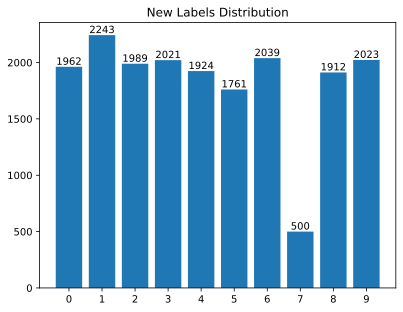

In [132]:
# {k:labels.count(k) for k in labels.detach()}

vals, counts = torch.unique(labels, return_counts = True)
plt.bar(vals, counts)
plt.xticks(vals)
plt.title('New Labels Distribution')
for x, v in zip(vals, counts):
  plt.text(x, v, f'{v}', ha='center', va='bottom')
plt.show()

## Split

In [134]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

## Model

In [135]:
def CreateNet():

  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 128)

      self.fc1 = nn.Linear(128,64)
      self.fc2 = nn.Linear(64,64)

      self.output = nn.Linear(64,10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return torch.log_softmax(x, axis = 1)

  net = Net()
  loss_fn = nn.NLLLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
  return net, loss_fn, optimizer

CreateNet()

(Net(
   (input): Linear(in_features=784, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=64, bias=True)
   (output): Linear(in_features=64, out_features=10, bias=True)
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [136]:
net, loss_fn, optimizer = CreateNet()
X, y = next(iter(train_dataloader))
y_hat = net(X)
loss = loss_fn(y_hat, y)
acc = 100 * torch.mean(
    (torch.argmax(y_hat, axis = 1) == y).float()
)
print(f'First spin Accuracy: {acc}% ')

First spin Accuracy: 9.375% 


## Train

In [141]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses, net

In [142]:
train_acc, test_acc, losses, net = ModelTrain(100, verbose = True)

Epoch: 0 | Train Acc: 22.47 | Test Acc: 38.29 | Loss: 2.27
Epoch: 10 | Train Acc: 90.97 | Test Acc: 90.04 | Loss: 0.31
Epoch: 20 | Train Acc: 94.87 | Test Acc: 93.99 | Loss: 0.17
Epoch: 30 | Train Acc: 97.24 | Test Acc: 95.07 | Loss: 0.10
Epoch: 40 | Train Acc: 98.31 | Test Acc: 94.83 | Loss: 0.06
Epoch: 50 | Train Acc: 99.26 | Test Acc: 95.86 | Loss: 0.04
Epoch: 60 | Train Acc: 99.61 | Test Acc: 95.76 | Loss: 0.02
Epoch: 70 | Train Acc: 99.85 | Test Acc: 95.95 | Loss: 0.01
Epoch: 80 | Train Acc: 99.97 | Test Acc: 95.97 | Loss: 0.01
Epoch: 90 | Train Acc: 99.97 | Test Acc: 96.03 | Loss: 0.01


## Performace Measures

In [156]:
y_hat = net(train_dataloader.dataset.tensors[0])
train_preds = torch.argmax(y_hat, axis = 1)

y_hat = net(test_dataloader.dataset.tensors[0])
test_preds = torch.argmax(y_hat, axis = 1)

In [159]:
import sklearn.metrics as skm

train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

train_metrics[0] = skm.accuracy_score(train_dataloader.dataset.tensors[1], train_preds)
train_metrics[1] = skm.precision_score(train_dataloader.dataset.tensors[1], train_preds, average = 'weighted')
train_metrics[2] = skm.recall_score(train_dataloader.dataset.tensors[1], train_preds, average = 'weighted')
train_metrics[3] = skm.f1_score(train_dataloader.dataset.tensors[1], train_preds, average = 'weighted')

test_metrics[0] = skm.accuracy_score(test_dataloader.dataset.tensors[1], test_preds)
test_metrics[1] = skm.precision_score(test_dataloader.dataset.tensors[1], test_preds, average = 'weighted')
test_metrics[2] = skm.recall_score(test_dataloader.dataset.tensors[1], test_preds, average = 'weighted')
test_metrics[3] = skm.f1_score(test_dataloader.dataset.tensors[1], test_preds, average = 'weighted')

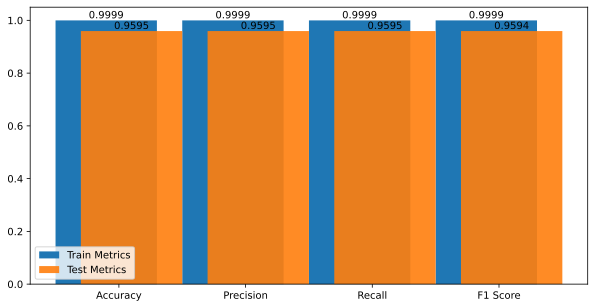

In [182]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

fig = plt.figure(figsize = (10,5))
plt.bar(np.arange(4) - .1, train_metrics, label = 'Train Metrics')
plt.bar(np.arange(4) + .1, test_metrics, alpha = .9, label = 'Test Metrics')
plt.xticks([0,1,2,3],metrics)
plt.legend()
for x, tr, te in zip(np.arange(4), train_metrics, test_metrics):
  plt.text(x - .1, tr, f'{tr:.4f}', ha = 'center', va = 'bottom')
  plt.text(x + .1, te, f'{te:.4f}', ha = 'center', va = 'bottom')
plt.show()

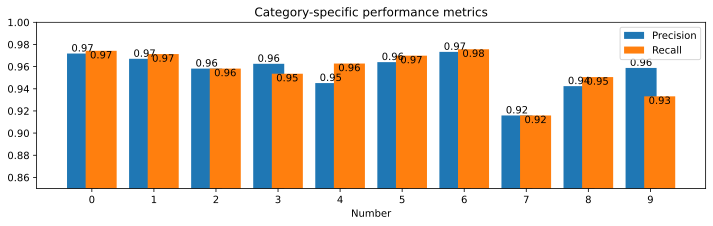

In [194]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_dataloader.dataset.tensors[1], test_preds, average = None)
recall = skm.recall_score(test_dataloader.dataset.tensors[1], test_preds, average = None)

fig = plt.figure(figsize = (12,3))
plt.bar(np.arange(10) - .15, precision, .5)
plt.bar(np.arange(10) + .15, recall, .5)
plt.xticks(range(10), range(10))
plt.ylim([.85, 1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Category-specific performance metrics')
for x, tr, te in zip(np.arange(10), precision, recall):
  plt.text(x - .15, tr, f'{tr:.2f}', ha = 'center', va = 'bottom')
  plt.text(x + .15, te, f'{te:.2f}', ha = 'center', va = 'top')
plt.show()

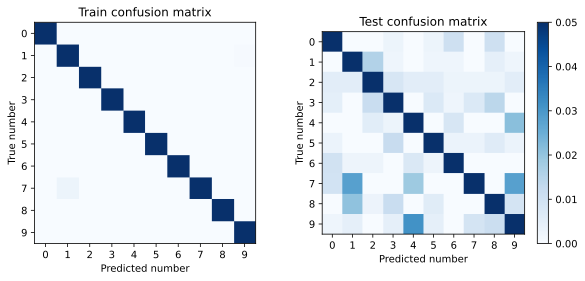

In [195]:
train_conf = skm.confusion_matrix(train_dataloader.dataset.tensors[1], train_preds, normalize = 'true')
test_conf = skm.confusion_matrix(test_dataloader.dataset.tensors[1], test_preds, normalize = 'true')

fig, ax = plt.subplots(1,2,figsize=(10,4))

# confmat during train
ax[0].imshow(train_conf, 'Blues', vmax = .05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('Train confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

a = ax[1].imshow(test_conf, 'Blues', vmax = .05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('Test confusion matrix')
ax[1].set_xlabel('True number')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

As we can see, the digit 7 achieves noticeably lower precision and recall compared to other classes. However, the decrease is not particularly significant, suggesting that the smaller number of samples for class 7 did not cause a proportionally large drop in its performance metrics.